# Build a Regular RAG Document Ingestion Pipeline  (No Ray required)


## Introduction

In this tutorial, we will build a document processing pipeline that accomplishes the following:

- Load various document formats (PDF, DOCX, PPTX, HTML, TXT) using Unstructured IO.
- Apply text chunking strategy (fixed and recursive) to  break down the text for further processing.
- Embedd the text chunk using a embedding model.
- Store the embeddings to Chroma DB for further document retrieval capabilities.

Here is the diagram of the architecture:

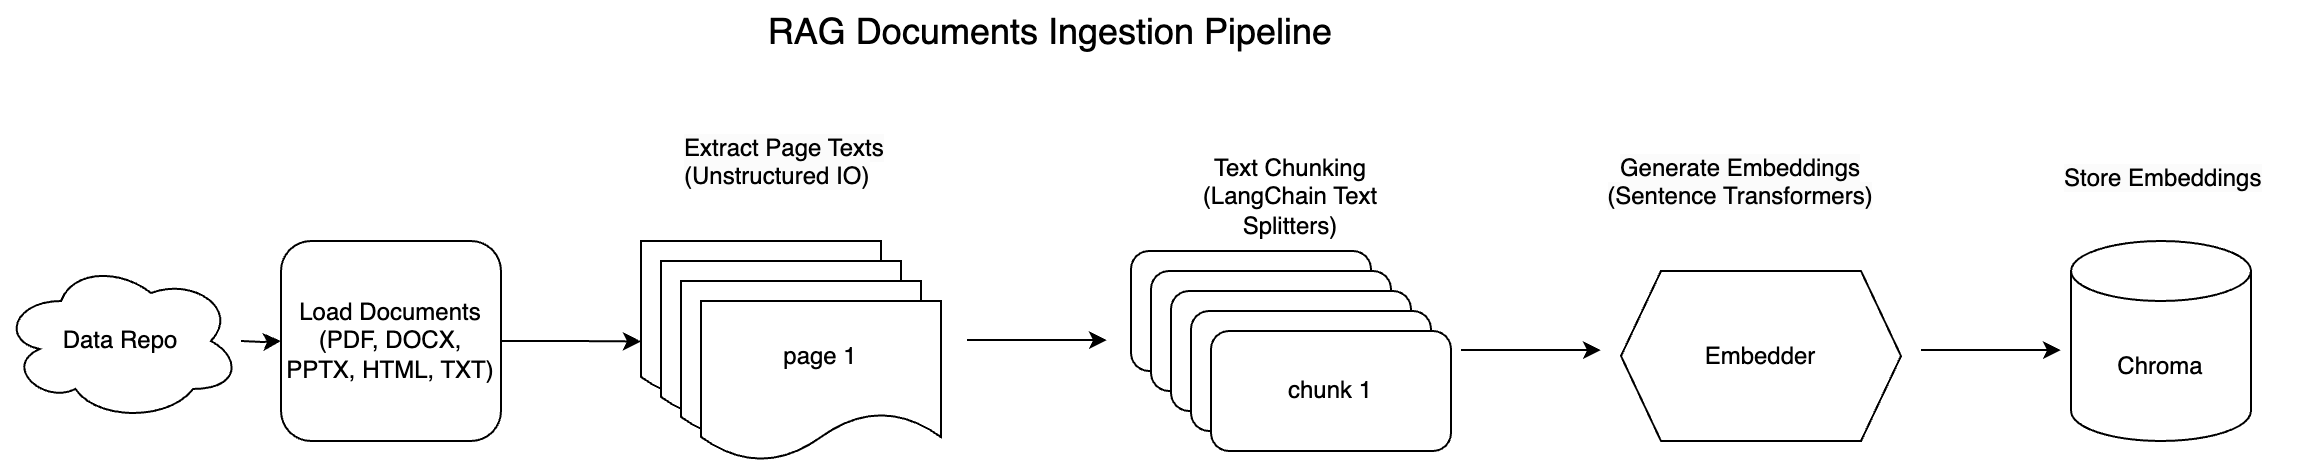


This pipeline is designed to prepare your data for downstream tasks while ensuring flexibility and effectiveness in handling diverse document types.

There is no RAY need for this tutorial—just familiarity with building RAG and unstructured document ingestion. **You can skip this tutorial if you are already familiar with RAG document ingesstion process.**

In Notebook #2, we will show more details on how to use Ray to scale this process for massive document processing.




<div class="alert alert-block alert-warning">
  <b>Anyscale-Specific Configuration</b>
  
  <p>Note: This tutorial is optimized for the Anyscale platform. When running on open source Ray, additional configuration is required. For example, you’ll need to manually:</p>
  
  <ul>
    <li>
      <b>Configure your Ray Cluster:</b> Set up your multi-node environment (including head and worker nodes) and manage resource allocation (e.g., autoscaling, GPU/CPU assignments) without the Anyscale automation. See the Ray Cluster Setup documentation for details: <a href="https://docs.ray.io/en/latest/cluster/getting-started.html">https://docs.ray.io/en/latest/cluster/getting-started.html</a>.
    </li>
    <li>
      <b>Manage Dependencies:</b> Install and manage dependencies on each node since you won’t have Anyscale’s Docker-based dependency management. Refer to the Ray Installation Guide for instructions on installing and updating Ray in your environment: <a href="https://docs.ray.io/en/latest/ray-core/handling-dependencies.html">https://docs.ray.io/en/latest/ray-core/handling-dependencies.html</a>.
    </li>
    <li>
      <b>Set Up Storage:</b> Configure your own distributed or shared storage system (instead of relying on Anyscale’s integrated cluster storage). Check out the Ray Cluster Configuration guide for suggestions on setting up shared storage solutions: <a href="https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html">https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html</a>.
    </li>
  </ul>

</div>


## Document Loading with Unstructured IO

Within the workspace, the folder named **`anyscale-jobs-docs`** contains **5** documents in various formats, including PDF, PPTX, HTML, TXT, and DOCX.

We define a function that loads and partitions these documents using the Unstructured IO library for parsing. For more information, please visit: https://docs.unstructured.io/welcome.

Documents are read from a specified directory and processed page by page. Each page’s text is grouped along with its corresponding metadata—such as source file details, file type, page number, and a unique document ID.

In [ ]:

import os
import re
from typing import List, Dict
from pathlib import Path  
import uuid


# Importing our document partitioner from unstructured.io
from unstructured.partition.auto import partition


def process_documents_pages(source_dir: str) -> List[Dict]:
    """
    Load documents from a given directory using Unstructured IO and group text by page number.

    Args:
        source_dir (str): Directory containing documents.

    Returns:
        List[Dict]: A list of dictionaries where each dictionary contains:
                    - 'text': combined text from a page,
                    - 'source': file path,
                    - 'file_name': file name with extension,
                    - 'file_type': file extension,
                    - 'page_number': page number,
                    - 'doc_id': a unique id for the entire file.
    """
    pages = []
    for file_path in Path(source_dir).rglob('*'):
        if file_path.suffix.lower() in ('.pdf', '.docx', '.pptx', '.html', '.txt'):
            print("processing file:", file_path)
            elements = partition(str(file_path))
            doc_id = str(uuid.uuid4())  # Single doc_id per file

            # Group text by page number
            page_texts = {}
            for el in elements:
                # Get the page number; default to 1 if not provided
                page_number = getattr(el.metadata, "page_number", None)
                page_number = int(page_number) if page_number is not None else 1
                
                # Append element text to the corresponding page's list
                page_texts.setdefault(page_number, []).append(str(el))
            
            # Create a document entry for each page
            for page_number, texts in page_texts.items():
                combined_text = " ".join(texts).strip()
                pages.append({
                    "text": combined_text,
                    "source": str(file_path),
                    "file_name": file_path.name,
                    "file_type": file_path.suffix,
                    "page_number": page_number,
                    "doc_id": doc_id
                })
    return pages


In [ ]:
source_directory = "./anyscale-jobs-docs"  # Replace with your actual folder path
pages = process_documents_pages(source_directory)

for page in pages:
    print(f"File Name: {page['file_name']}")
    print(f"Page Number: {page['page_number']}")
    print(f"Text: {page['text'][:200]}...")  # Truncate text to 100 characters
    print("-" * 80)  # Separator for readability


processing file: anyscale-jobs-docs/Create_and_manage_jobs.pdf
processing file: anyscale-jobs-docs/Job_queues.pptx
processing file: anyscale-jobs-docs/Monitor_a_job.docx
processing file: anyscale-jobs-docs/Jobs.txt
processing file: anyscale-jobs-docs/Job_schedules.html
File Name: Create_and_manage_jobs.pdf
Page Number: 1
Text: 2/12/25, 9:48 AM Create and manage jobs | Anyscale Docs Create and manage jobs Submitting a job To submit your job to Anyscale, use the Python SDK or CLI and pass in any additional options or configur...
--------------------------------------------------------------------------------
File Name: Create_and_manage_jobs.pdf
Page Number: 2
Text: 2/12/25, 9:48 AM Create and manage jobs | Anyscale Docs Defining a job With the CLI, you can define jobs in a YAML file and submit them by referencing the YAML: anyscale job submit --config-file confi...
--------------------------------------------------------------------------------
File Name: Create_and_manage_jobs.pdf
Page

##  Chunking Strategies

This section demonstrates various strategies to divide a document into smaller, manageable text chunks using specialized text splitters. `ChunkingStrategy` class allow users to split text into smaller chunks using either a "fixed" or "recursive" method, with configurable parameters like encoding type, chunk size, and overlap. 


In [ ]:
## doc: https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/

from typing import List
# Importing various text splitters for different chunking strategies
from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter
)

class ChunkingStrategy:
    def __init__(self, method: str = 'recursive', encoding_name: str = "cl100k_base", 
                 chunk_size: int = 300, chunk_overlap: int = 50):
        """
        Initialize a chunking strategy.

        Args:
            method (str): The chunking method, e.g. 'fixed' or 'recursive'.
            encoding_name (str): The name of the encoding to use.
            chunk_size (int): The size of each chunk.
            chunk_overlap (int): The overlap between chunks.
        """
        self.method = method
        self.encoding_name = encoding_name
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

    def chunk_document(self, text: str) -> List[str]:
        """
        Chunk a document's text using the selected strategy.

        Args:
            text (str): The document's text to chunk.

        Returns:
            List[str]: A list of text chunks.
        """
        if self.method == 'fixed':
            splitter = CharacterTextSplitter.from_tiktoken_encoder(
                encoding_name=self.encoding_name, 
                chunk_size=self.chunk_size, 
                chunk_overlap=self.chunk_overlap
            )
            return splitter.split_text(text)
        elif self.method == 'recursive':
            splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
                encoding_name=self.encoding_name, 
                chunk_size=self.chunk_size, 
                chunk_overlap=self.chunk_overlap
            )
            return splitter.split_text(text)
        else:
            raise ValueError("Unknown chunking method: choose 'fixed' or 'recursive'.")
    

## Test the Chunking Strategy Implementation

Now let's put the chunking process in action for a single page:

In [ ]:
## Test the Chunking Strategy Implementation

# Create a ChunkingStrategy instance with the desired settings.
chunker = ChunkingStrategy(chunk_size=300, chunk_overlap=50)

# Retrieve page information from the pages list (using the 11th page as an example).
page = pages[10]
file_name = page["file_name"]
file_type = page["file_type"]
page_number = page["page_number"]
text_content = page["text"]

# Debug: Print the text content of the selected page.
print("Debug - Page Text:", text_content)

# Chunk the document text using the chunk_document method.
chunks = chunker.chunk_document(text_content)

# Display file and page details along with the number of chunks generated.
print(f"File: {file_name} (Page Number: {page_number})")
print(f"Number of chunks: {len(chunks)}")
print("-" * 80)

# Iterate through each chunk and print its contents.
for idx, chunk in enumerate(chunks):
    print(f"Chunk {idx + 1}:")
    print(chunk)
    print("-" * 80)

Debug - Page Text: Monitor a job Anyscale jobs provides several tools to monitor your jobs: Job detail page Metrics Logs Alerts Ray Dashboard Exporting logs and metrics This document describes each use case and provides suggestions for when to use each tool. Job detail page The job detail page contains the status of the job, information about your job's configuration, details about each job attempt, events of the job, and links to various other tools. The job events log is at the bottom of the page. This log lists events of your job aAnsdkinAcIludes events about your job lifecycle and errors. Metrics Access metrics related to your job in the Metrics tab of the job detail page. Job metrics tracks hardware metrics and system-level metrics such as CPU or network utilization, memory, or disk usage, node count, number of Ray tasks, and number of active Ray actors. Metrics are also available in Grafana for a more advanced UI, which allows you to create custom dashboards for visualizing the m

Now let's Chunk all documents and collect chunks along with metadata

In [ ]:
import uuid

all_chunks = []

for page in pages:
    chunks = chunker.chunk_document(page["text"])
    
    for chunk in chunks:
        all_chunks.append({
            "id": str(uuid.uuid4()),  # Generate a unique ID for each chunk
            "text": chunk,
            "metadata": {
                "source": page["source"],
                "doc_id": page["doc_id"],
                "file_name": page["file_name"],
                "file_type": page["file_type"],
                "page_number": page["page_number"],
                "chunk_method": chunker.method
            }
        })

print(f"Created {len(all_chunks)} text chunks.")


Created 22 text chunks.


##  Generate Embeddings 

Before setting up Chroma DB for vector storage, generate embeddings for your text chunks. 
We are using `intfloat/multilingual-e5-large-instruct` model. 

In [ ]:

from sentence_transformers import SentenceTransformer

# Initialize a SentenceTransformer model (choose one appropriate for your use case)
embed_model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")

# Gather all chunk texts for embedding generation
chunk_texts = [chunk["text"] for chunk in all_chunks]

# Compute embeddings (using batch encoding for efficiency)
embeddings = embed_model.encode(chunk_texts, convert_to_numpy=True, show_progress_bar=True)

# Attach each embedding (converted to a list) to the corresponding chunk
for i, chunk in enumerate(all_chunks):
    chunk["embedding"] = embeddings[i].tolist()

print("Embeddings generated and attached to each chunk.")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embeddings generated and attached to each chunk.


## Set up Chroma DB

We are using ChromaDB to store and manage our computed embeddings. For demo purpose, a temporary directory is initialized for persistent storage, and a ChromaDB client is created along with a collection named "sample_embeddings" to hold the embeddings, associated metadata, and document texts.

In [ ]:
import tempfile
import chromadb
from sentence_transformers import SentenceTransformer

# Create a temporary directory
temp_dir = tempfile.TemporaryDirectory()
temp_chroma_db_path = temp_dir.name  # This is the path for ChromaDB storage

# Initialize ChromaDB client
chroma_client = chromadb.PersistentClient(path=temp_chroma_db_path)  # Change path as needed
collection = chroma_client.get_or_create_collection(name="sample_embeddings")
# Store embeddings in ChromaDB
collection.add(
    ids=[chunk["id"] for chunk in all_chunks],
    embeddings=embeddings.tolist(),
    metadatas=[chunk["metadata"] for chunk in all_chunks],
    documents=chunk_texts
)

print("Embeddings stored in ChromaDB.")

Embeddings stored in ChromaDB.


## Embedding Search with Chroma

we perform a search for relevant document embeddings stored in ChromaDB. By generating an embedding for a given text query, we can identify and retrieve the most similar documents from the collection, along with their metadata and similarity scores.

In [ ]:
from pprint import pprint
# Define your text query
query_text = "how to submit anyscale jobs"

# Generate the embedding for the query text
query_embedding = embed_model.encode(query_text).tolist()

# Query the collection for the top 3 most similar documents.
# The 'include' parameter lets you retrieve documents, metadatas, and distances.
results = collection.query(
    query_embeddings=[query_embedding],
    n_results=3,
    include=["documents", "metadatas", "distances"]
)

# Print the retrieval results
print("Query Results:")
pprint(results)

Query Results:
{'data': None,
 'distances': [[0.18700521448677737, 0.18982562470474848, 0.1924720483496574]],
 'documents': [['Create and manage jobs Submitting a job\u200b To submit your '
                'job to Anyscale, use the Python SDK or CLI and pass in any '
                'additional options or configurations for the job. By default, '
                'Anyscale uses your workspace or cloud to provision a cluster '
                'to run your job. You can define a custom cluster through a '
                'compute config or specify an existing cluster. Once '
                'submitted, Anyscale runs the job as specified in the '
                'entrypoint command, which is typically a Ray Job. If the run '
                "doesn't succeed, the job restarts using the same entrypoint "
                'up to the number of max_retries. CLI Python SDK anyscale job '
                'submit --name=my-job \\\n'
                '  --working-dir=. --max-retries=5 \\\n'
          

## Reformat Chroma Search Results

The embedding search results returned from Chroma are not intuitive, so let's reformat them:

In [ ]:
from pprint import pprint
def reformat(chroma_results: dict) -> list:
    """
    Reformat chroma db results to a list of search items containing:
    - chunk_id
    - chunk_index
    - doc_id
    - page_number
    - source
    - text (from documents)
    - distance
    - score

    Parameters:
        chroma_results (dict): The raw results from the Chroma DB query.

    Returns:
        list: A list of dictionaries with the desired keys.
    """
    reformatted = []
    
    # Get the lists from the results. They are expected to be lists of lists.
    metadatas = chroma_results.get("metadatas", [])
    documents = chroma_results.get("documents", [])
    distances = chroma_results.get("distances", [])
    
    # Loop over each group (each inner list represents one set of matches)
    chunk_index = 1
    for meta_group, doc_group, distance_group in zip(metadatas, documents, distances):
        # Iterate over each item in the inner lists
        for meta, text, distance in zip(meta_group, doc_group, distance_group):
            item = {
                "chunk_index": chunk_index,
                "chunk_id": meta.get("chunk_id"),
                "doc_id": meta.get("doc_id"),
                "page_number": meta.get("page_number"),
                "source": meta.get("source"),
                "text": text,
                "distance": distance,
                "score": 1 - distance
            }
            reformatted.append(item)
            chunk_index += 1
    
    return reformatted


print("refromat Results:")
pprint(reformat(results))

refromat Results:
[{'chunk_id': None,
  'chunk_index': 1,
  'distance': 0.18700521448677737,
  'doc_id': 'fc073a75-025a-4b5e-8192-7a3a73f92739',
  'page_number': 1,
  'score': 0.8129947855132227,
  'source': 'anyscale-jobs-docs/Job_schedules.html',
  'text': 'Create and manage jobs Submitting a job\u200b To submit your job to '
          'Anyscale, use the Python SDK or CLI and pass in any additional '
          'options or configurations for the job. By default, Anyscale uses '
          'your workspace or cloud to provision a cluster to run your job. You '
          'can define a custom cluster through a compute config or specify an '
          'existing cluster. Once submitted, Anyscale runs the job as '
          'specified in the entrypoint command, which is typically a Ray Job. '
          "If the run doesn't succeed, the job restarts using the same "
          'entrypoint up to the number of max_retries. CLI Python SDK anyscale '
          'job submit --name=my-job \\\n'
       

## Why it's not scalable

The current regular RAG document ingestion approach processes documents sequentially, without utilizing parallelization. This lack of parallel processing creates a bottleneck when managing large volumes of data. Without distributed processing, scaling to thousands of documents — each potentially containing dozens or even hundreds of pages — can quickly overwhelm the resources of a single machine.

Moreover, embedding all text chunks in a single operation can result in substantial memory constraints and cause performance degradation, further exacerbating the issue.

In the next notebook, we will demonstrate how to leverage **`RayData`** to build a scalable document ingestion pipeline. By utilizing Ray’s distributed computing capabilities, we can significantly improve processing efficiency, reduce bottlenecks, and enable seamless scaling for large-scale document ingestion.